# Quantum Fourier Transform (QFT)
## Análisis de una señal discretizada con ruido, simlación de una SEÑAL SETI en banda de 1420 Mhz.

---

## 1. Enunciado del problema

Disponemos de una señal discreta contaminada con ruido.  
El objetivo es **identificar sus componentes frecuenciales dominantes** utilizando la Quantum Fourier Transform (QFT).

No buscamos eliminar el ruido, sino **revelar estructura periódica** oculta en la señal mediante interferencia cuántica.

---

## 2. Idea física y computacional

En procesamiento clásico de señales, la Transformada Discreta de Fourier (DFT) transforma una señal del dominio temporal al dominio de frecuencias.

La QFT es la versión cuántica de este proceso:  
actúa sobre un estado cuántico y **codifica la información frecuencial en las fases relativas del estado**, no en amplitudes explícitas.

La QFT no calcula todos los coeficientes de Fourier:
- prepara una superposición
- introduce fases correlacionadas
- permite que la interferencia destaque ciertas frecuencias al medir

---

## 3. Representación cuántica de la señal

Consideremos una señal discreta $x_n$ con $N = 2^n$ muestras.

La codificamos como un estado cuántico:

$$
|\psi\rangle = \sum_{n=0}^{N-1} x_n |n\rangle
$$

En la práctica, para un demostrador:
- se prepara un estado base
- se introduce una fase periódica dominante
- se añade ruido como pequeñas perturbaciones de fase o amplitud

---

## 4. Qué hace la QFT paso a paso

La QFT implementa la transformación:

$$
|x\rangle \rightarrow \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} e^{2\pi i x k / N} |k\rangle
$$

Circuitalmente:

1. Cada qubit entra en superposición mediante una compuerta Hadamard
2. Se aplican compuertas de fase controlada que introducen correlaciones de fase
3. Se reorganizan los qubits (SWAP) para corregir el orden binario
4. La interferencia hace que ciertas frecuencias tengan mayor probabilidad de medición

---

## 5. Qué se observa al medir

Al medir el estado final:
- aparecen picos de probabilidad asociados a las frecuencias dominantes
- el ruido se manifiesta como distribución difusa alrededor de esos picos

La QFT **no limpia el ruido**, pero:
- separa estructura (periodicidad)
- de desorden (ruido no correlacionado)

---

## 6. Qué NO hace la QFT

- No filtra ruido automáticamente
- No reconstruye la señal original
- No ofrece ventaja clásica directa en análisis de señales aislado

Su valor está en ser:
> un bloque fundamental de algoritmos cuánticos basados en fase e interferencia

---


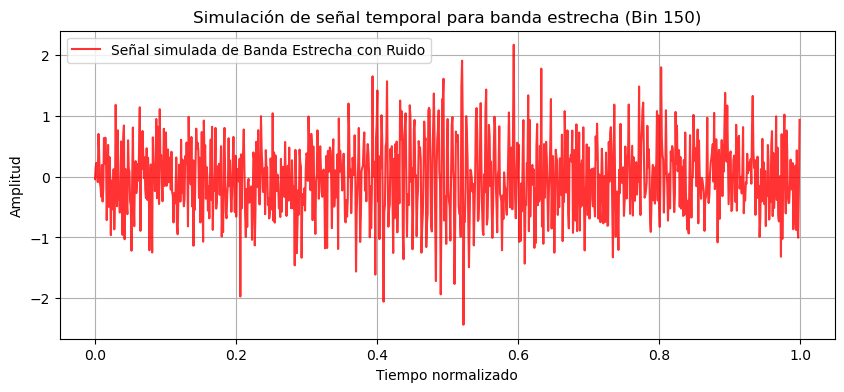

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator

# --- 1. Definición y preparación de la señal clásica de 1420 MHz ---

# N = 2^10 = 1024 muestras para buena resolución
N_QUBITS = 10
N_SAMPLES = 2**N_QUBITS 
SHOTS = 50000

# Supongamos una frecuencia de muestreo Fs, por ejemplo 10 MHz
# Esto hace que nuestro rango de frecuencias (ancho de banda de Nyquist) sea de +/- 5 MHz
# El bin 1420 MHz está fuera de este rango, por lo que escalaremos las unidades a kHz relativos
# para que la frecuencia de interes caiga dentro de nuestros bins discretos.

# Frecuencia simulada de interés (ejemplo: 420 kHz dentro de un rango de 1024 bins)
# Elegimos un bin entero para que la QFT lo detecte perfectamente
center_frequency_bin = 150 # Un bin de frecuencia específico dentro de nuestro rango N/2

# Creamos una señal muy estrecha alrededor de ese bin
t = np.linspace(0, 1, N_SAMPLES, endpoint=False)
# Usamos una función sinc para simular una señal de banda estrecha en el dominio temporal
# La transformada de Fourier de un filtro rectangular (banda estrecha) en frecuencia es una función sinc en el tiempo.

def narrow_band_signal(t, center_bin, N_samples, bandwidth_bins=5):
    # Esto es una aproximación para generar una señal en el tiempo que *tenga* un espectro de banda estrecha
    freq_norm = center_bin / N_samples
    signal = np.sinc(bandwidth_bins * (t - 0.5)) * np.cos(2 * np.pi * freq_norm * N_samples * t)
    return signal

signal = narrow_band_signal(t, center_frequency_bin, N_SAMPLES)

# Añadir ruido aleatorio significativo (SNR bajo)
noise_level = 0.5
noisy_signal = signal + np.random.normal(0, noise_level, N_SAMPLES)

# Visualización de la señal en el dominio temporal
plt.figure(figsize=(10, 4))
plt.plot(t, noisy_signal, label='Señal simulada de Banda Estrecha con Ruido', color='red', alpha=0.8)
plt.title(f'Simulación de señal temporal para banda estrecha (Bin {center_frequency_bin})')
plt.xlabel('Tiempo normalizado')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()





C:\Users\migue\AppData\Local\Temp\ipykernel_22008\2508303493.py:6: DeprecationWarning:

The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)



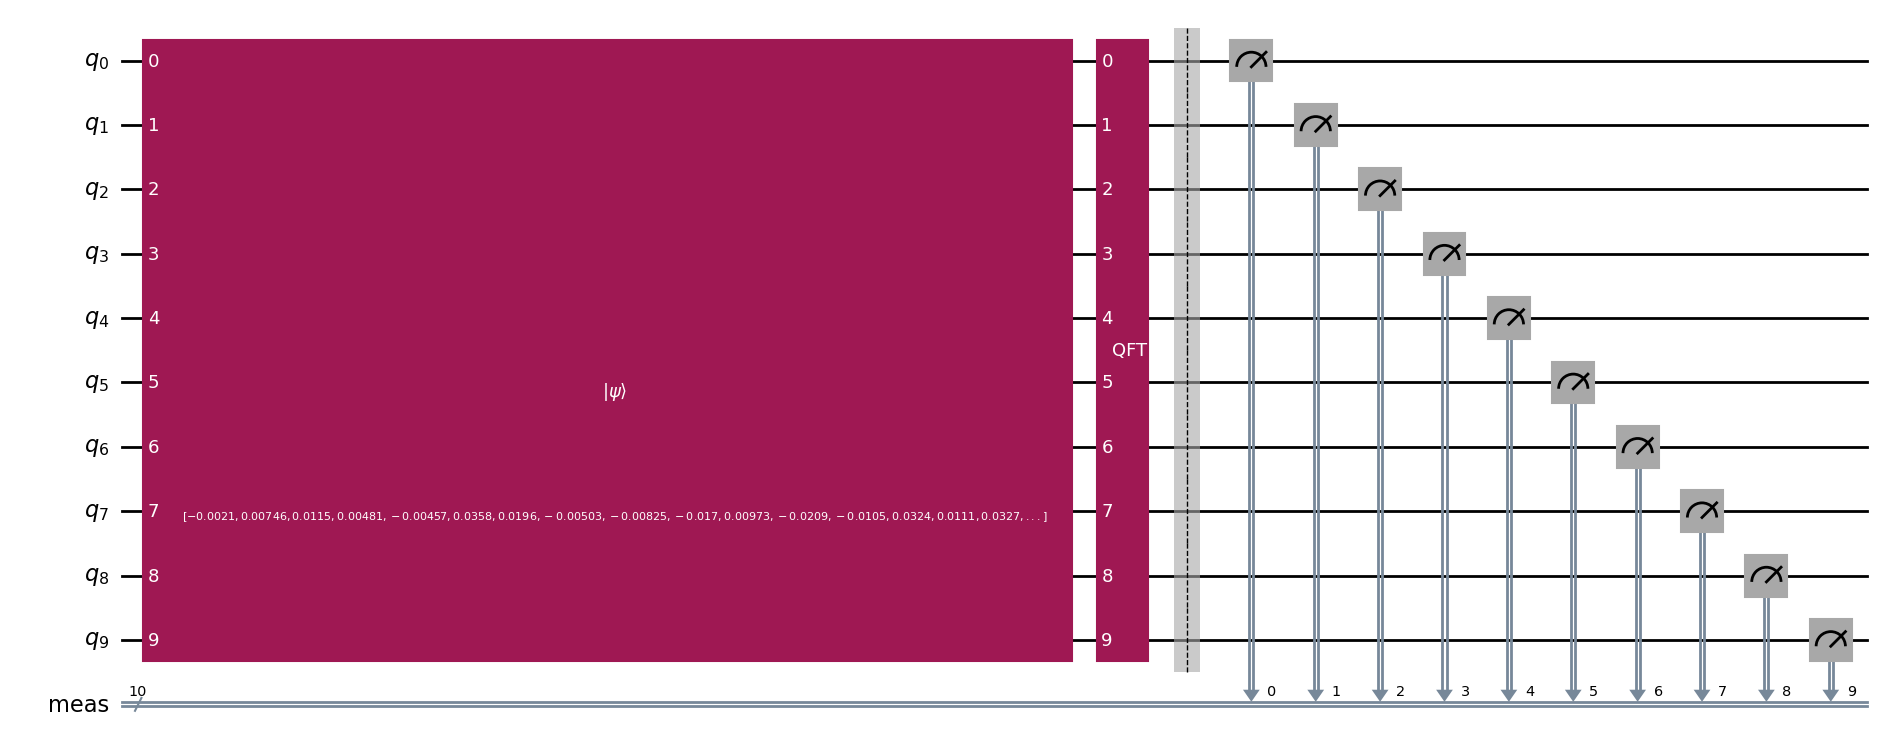

In [233]:
# --- 2. Codificación cuántica y QFT ---

amplitudes = noisy_signal / np.linalg.norm(noisy_signal)
qc = QuantumCircuit(N_QUBITS)
qc.initialize(amplitudes, range(N_QUBITS))
qc.append(QFT(N_QUBITS, inverse=False), range(N_QUBITS))
qc.measure_all()
qc.draw('mpl', fold=-1)

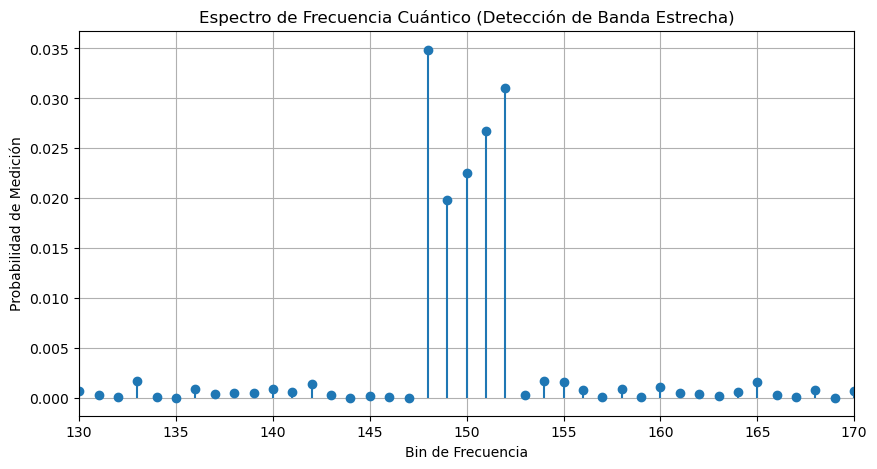


Bin de frecuencia esperado: 150
Bin más probable detectado por QFT: 148


In [234]:
# --- 3. Simulación y obtención de CONTEOS ---

simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=SHOTS).result() # Muchos shots para precisión
counts = result.get_counts(qc)

# --- 4. Análisis y Visualización del ESPECTRO (Estilo "Stem Plot") ---

freq_bins = np.arange(N_SAMPLES) 
probabilities = np.zeros(N_SAMPLES)
for state_string, count in counts.items():
    bin_index = int(state_string, 2)
    probabilities[bin_index] = count / SHOTS

plt.figure(figsize=(10, 5))
plt.stem(freq_bins, probabilities, basefmt=" ")

plt.title('Espectro de Frecuencia Cuántico (Detección de Banda Estrecha)')
plt.xlabel('Bin de Frecuencia')
plt.ylabel('Probabilidad de Medición')
# Limitar a la región donde está nuestro pico
plt.xlim(center_frequency_bin - 20, center_frequency_bin + 20) 
plt.grid(True)
plt.show()

# Imprimir el bin más probable
most_likely_bin = np.argmax(probabilities[:N_SAMPLES//2])
print(f"\nBin de frecuencia esperado: {center_frequency_bin}")
print(f"Bin más probable detectado por QFT: {most_likely_bin}")

# Algoritmo de Grover
## Búsqueda en un dataset no estructurado de 4 bits

---

## 1. Enunciado del problema

Se dispone de un conjunto no estructurado de números binarios de 4 bits, es decir, $2^4 = 16$ posibles elementos.

Uno de ellos está marcado como “solución”, pero:
- no hay orden
- no hay métrica
- no hay estructura aprovechable

El objetivo es **encontrar el elemento marcado** usando el algoritmo de Grover.

---

## 2. Idea física y computacional

Clásicamente, encontrar un elemento en un conjunto no estructurado requiere, en promedio, $N/2$ consultas.

Grover demuestra que, usando **interferencia cuántica**, es posible encontrarlo en aproximadamente:

$$
O(\sqrt{N})
$$

La clave no es “probar más rápido”, sino:
> **amplificar la probabilidad del estado correcto**

---

## 3. Preparación del estado inicial

Se comienza preparando una superposición uniforme de todos los estados posibles:

$$
|\psi_0\rangle = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} |x\rangle
$$

Esto se logra aplicando compuertas Hadamard a todos los qubits.

---

## 4. El Oracle (marcado de la solución)

El oracle es una operación que:
- NO revela la solución
- NO mide el estado
- SOLO cambia la fase del estado correcto

Formalmente:

$$
|x\rangle \rightarrow (-1)^{f(x)} |x\rangle
$$

donde $f(x)=1$ solo para el elemento buscado.

---

## 5. El difusor (amplificación de amplitud)

El difusor realiza una reflexión respecto al valor medio de las amplitudes.

Intuitivamente:
- los estados “equivocados” se atenúan
- el estado correcto se refuerza

Oracle + Difusor = **una iteración de Grover**

---

## 6. Número de iteraciones

Para $N = 16$:

$$
k \approx \frac{\pi}{4} \sqrt{16} \approx 3
$$

Demasiadas iteraciones hacen que la probabilidad vuelva a disminuir.

---

## 7. Qué se observa al medir

Tras las iteraciones adecuadas:
- el estado marcado aparece con alta probabilidad
- el resultado es probabilístico, no determinista

---

## 8. Qué NO hace Grover

- No ordena datos
- No encuentra máximos o mínimos
- No da ventaja si el problema ya tiene estructura

Grover solo acelera **búsqueda no estructurada**.

---


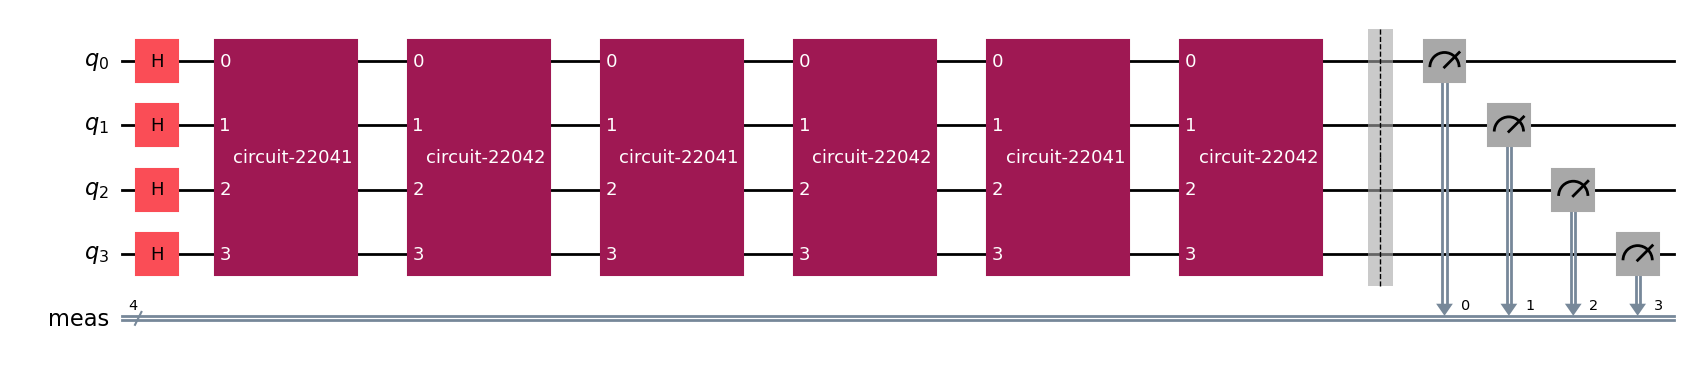

In [240]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np

# Parámetros globales del circuito
N_QUBITS = 4            # Define el número de qubits (tamaño del dataset: 2^4 = 16 elementos)
N_STATES = 2**N_QUBITS  # Número total de estados posibles (16)
TARGET_STATE = "1011"   # El elemento marcado o buscado en el dataset
SHOTS = 2000            # Número de veces que se simula el circuito para obtener estadísticas de medición

# --- Oracle ---
# El oráculo marca el estado objetivo invirtiendo su fase.
def grover_oracle(n_qubits, target):
    qc = QuantumCircuit(n_qubits)
    # Preparación: Invertir bits del objetivo para que coincidan con |11...1>
    # Esto es necesario para usar un MCX (Multi-Controlled X) en la siguiente etapa.
    for i, bit in enumerate(reversed(target)):
        if bit == "0":
            qc.x(i) # Aplica X (NOT) a los qubits que deben ser |0> en el estado objetivo.

    # Aplicación de la Inversión de Fase Controlada (Z condicional)
    qc.h(0)
    # mcx(control_qubits, target_qubit):
    # Aplica X al qubit 0 SOLO si todos los demás qubits (1 a N-1) están en |1>.
    # Esto implementa la fase -1 si y solo si el estado es el objetivo.
    qc.mcx(list(range(1, n_qubits)), 0)
    qc.h(0)

    # Restauración: Deshace la preparación para volver al estado objetivo original en base computacional.
    for i, bit in enumerate(reversed(target)):
        if bit == "0":
            qc.x(i)
    return qc

# --- Difusor ---
# El operador de difusión amplifica la amplitud del estado marcado y disminuye las demás.
def diffuser(n_qubits):
    qc = QuantumCircuit(n_qubits)
    # 1. Transformación al espacio de Hadamard (base de superposición).
    qc.h(range(n_qubits))
    # 2. Inversión alrededor de la media (equivale a una inversión de fase en el espacio de superposición).
    qc.x(range(n_qubits)) # Prepara los estados para el MCX (invierte 0s y 1s)
    qc.h(0)
    qc.mcx(list(range(1, n_qubits)), 0) # Aplica fase -1 si todos los qubits son |1>
    qc.h(0)
    qc.x(range(n_qubits)) # Deshace la preparación
    # 3. Vuelve al espacio computacional.
    qc.h(range(n_qubits))
    return qc

# ----------------------------------------------------
# Circuito principal
qc = QuantumCircuit(N_QUBITS)

# Superposición inicial: Prepara todos los qubits en estado |+>
# Esto crea una superposición uniforme de todos los 2^N_QUBITS estados posibles.
qc.h(range(N_QUBITS))

# Número óptimo de iteraciones de Grover (fórmula para 1 elemento marcado)
# sqrt(N) * pi/4 es el número de rotaciones necesarias para maximizar la probabilidad.
iterations = int(np.floor(np.pi / 4 * np.sqrt(N_STATES)))
# Nota: Para N_QUBITS=4, N_STATES=16, iterations = floor(pi/4 * 4) = floor(3.14) = 3 iteraciones.

# Construcción de los bloques reusables
oracle = grover_oracle(N_QUBITS, TARGET_STATE)
diff = diffuser(N_QUBITS)

# Aplica el bucle principal del algoritmo: Oracle + Difusor 'iterations' veces
for _ in range(iterations):
    qc.append(oracle, range(N_QUBITS)) # Aplica la inversión de fase
    qc.append(diff, range(N_QUBITS))   # Aplica la amplificación de amplitud


# Añade mediciones a todos los qubits para colapsar el estado cuántico en un resultado clásico
qc.measure_all()

# Dibuja el circuito usando matplotlib para visualización
qc.draw('mpl')
# ----------------------------------------------------


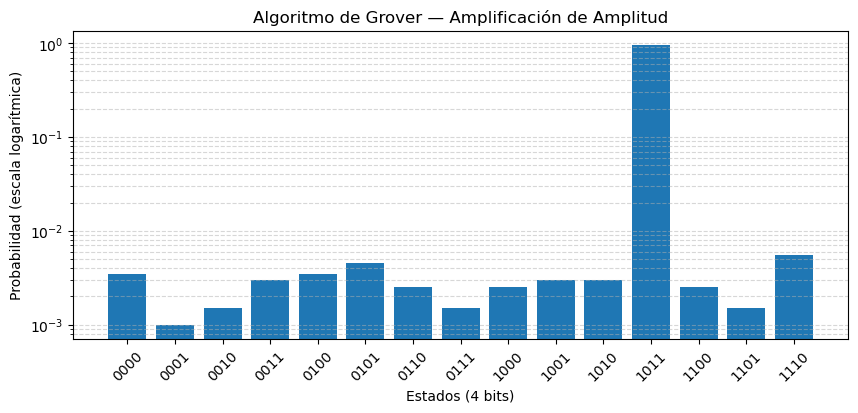

Estado marcado esperado: 1011
Estado más probable medido: 1011


In [241]:

# Simulación
simulator = AerSimulator()
compiled = transpile(qc, simulator)
result = simulator.run(compiled, shots=SHOTS).result()
counts = result.get_counts()

# --- Conversión a probabilidades ---
states = sorted(counts.keys())
probabilities = [counts[s] / SHOTS for s in states]

plt.figure(figsize=(10, 4))
plt.bar(states, probabilities)
plt.yscale("log")
plt.xlabel("Estados (4 bits)")
plt.ylabel("Probabilidad (escala logarítmica)")
plt.title("Algoritmo de Grover — Amplificación de Amplitud")
plt.xticks(rotation=45)
plt.grid(axis="y", which="both", linestyle="--", alpha=0.5)
plt.show()


# Estado más probable
most_probable = max(counts, key=counts.get)
print(f"Estado marcado esperado: {TARGET_STATE}")
print(f"Estado más probable medido: {most_probable}")

# Shor paso a paso: ejemplo con N = 15

 Shor es un algoritmo que puede ser complejo, este es un ejemplo **muy concreto y pequeño** para  factorizar \(N = 15\), 

---

### **Paso 0: Preparación**

Queremos factorizar \(N = 15\). Los factores reales son 3 y 5, se comprobarán usando Shor.

---

### **Paso 1: Elegir base y verificar coprimalidad**

Elegimos un número \(a\) al azar entre 2 y 14. Supongamos:

\[
a = 2
\]

Ahora calculamos MCD(a, N) = MCD(2, 15).

* MCD(2,15) = 1, así que **no encontramos un factor clásico**, revisamos el componente cuántico.

---

### **Paso 2: Superposición y exponenciación modular**

Aquí es donde ocurre la magia cuántica:

* Se contruye un registro con todos los valores \(x\) posibles: \(x = 0,1,2,...\)
* Se calcula $ f(x) = 2^x \mod 15 $:

| \(x\) | $ 2^x \mod 15 $ |
| --- | ------------- |
| 0   | 1             |
| 1   | 2             |
| 2   | 4             |
| 3   | 8             |
| 4   | 16 mod 15 = 1 |
| 5   | 2             |
| 6   | 4             |
| 7   | 8             |
| 8   | 1             |

Entonces: **el patrón se repite cada 4 pasos**, por lo que el período \(r = 4\).

---
# Construcción de una función de multiplicación modular controlada

Queremos implementar una operación cuántica que haga:

$$
|x\rangle |y\rangle \longrightarrow |x\rangle |y \cdot a \mod N\rangle
$$

donde:

- $|x\rangle$ es un **qubit de control** (o registro de control).  
- $|y\rangle$ es el **registro objetivo** que contiene el valor que multiplicaremos módulo $N$.  
- $a$ es la base elegida (por ejemplo $a=2$ o $a=4$).  
- $N$ es el número que queremos factorizar (por ejemplo $N=15$).

---

### **Paso 1: Definir el registro objetivo**

Primero necesitamos un circuito cuántico que actúe sobre el **registro objetivo**.  
El registro debe tener suficientes qubits para representar todos los valores hasta $N-1$ en binario.  

Por ejemplo, para $N=15$, necesitamos 4 qubits porque:

$$
15 = 1111_2
$$

---

### **Paso 2: Implementar la multiplicación modular como permutación de estados**

Para valores pequeños de $N$, podemos implementar $y \cdot a \mod N$ como **una permutación de los estados del registro objetivo**.  

Por ejemplo, para $a=2$ y $N=15$, los estados relevantes son:

$$
|1\rangle, |2\rangle, |4\rangle, |8\rangle
$$

y la multiplicación por 2 módulo 15 produce:

$$
1 \mapsto 2, \quad 2 \mapsto 4, \quad 4 \mapsto 8, \quad 8 \mapsto 1
$$

Esta permutación se puede realizar usando **SWAPs entre los qubits**, reordenando los bits del registro objetivo para reflejar la operación modular.

---


### **Paso 3: Convertir el subcircuito en una compuerta reutilizable**

Una vez implementada la permutación, el subcircuito se puede **convertir en una compuerta unitaria** que se puede reutilizar varias veces en el circuito principal.  

Se recomienda asignarle un nombre descriptivo, como $M_2$ o $M_4$, para identificar fácilmente qué operación modular representa.

---

### **Paso 4: Crear la versión controlada**

Para que la multiplicación ocurra **solo si el qubit de control está en $|1\rangle$**, se crea una **compuerta controlada** a partir del subcircuito:

$$
|c\rangle |y\rangle \longrightarrow
\begin{cases}
|0\rangle |y\rangle & \text{si } c=0 \\
|1\rangle |y \cdot a \mod N\rangle & \text{si } c=1
\end{cases}
$$

Esta compuerta controlada se puede **componer en el circuito principal**, aplicando la multiplicación modular solo cuando el qubit de control está activado.

---
## Tranformada de Fourier y la Medición

### **Paso 1: Transformada de Fourier y medición**

La Transformada Cuántica de Fourier (QFT) nos permite extraer el período \(r\).

* Al medir el primer registro, obtenemos un valor que nos ayuda a deducir \(r = 4\) usando **fracciones continuas**.
* Ya tenemos el período \(r\).

---

### **Paso 2: Post-procesamiento clásico**

Como \(r\) es **par**, usamos la identidad:

$$
a^r - 1 \text{ entonces }  2^4 - 1 \text{ entonces }  16 - 1 = 15
$$

Calculamos:

$$
\text{Factor 1} = MCD(2^{r/2} - 1, 15) = MCD(2^2 - 1, 15) = MCD(3, 15) = 3
$$

$$
\text{Factor 2} = MCD(2^{r/2} + 1, 15) = MCD(2^2 + 1, 15) = MCD(5, 15) = 5
$$

 ¡Se Encuentran los factores! 3 y 5

---



C:\Users\migue\AppData\Local\Temp\ipykernel_22008\1336755310.py:77: DeprecationWarning:

The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)



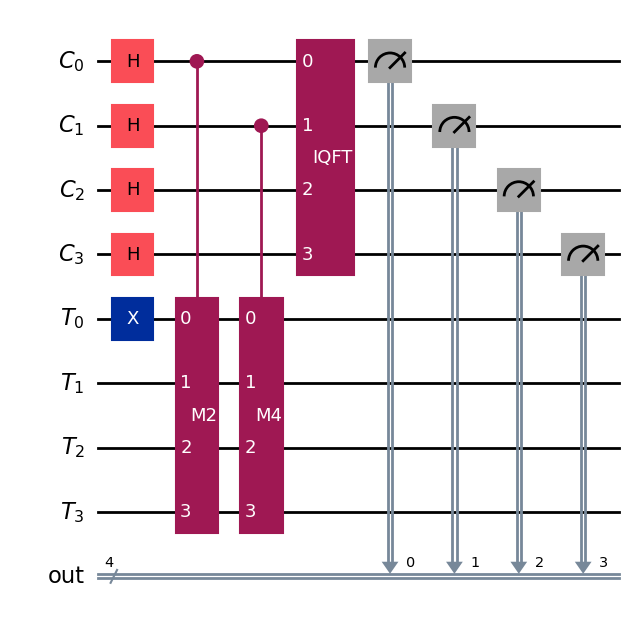

In [266]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT



# -------------------------------
# Parámetros de Shor para N=15, a=2
# -------------------------------
N = 15
a = 2
num_target = 4
num_control = 4  # suficiente para N=15 en demostración

# Crear registros
control = QuantumRegister(num_control, 'C')
target = QuantumRegister(num_target, 'T')
output = ClassicalRegister(num_control, 'out')

circ = QuantumCircuit(control, target, output)

# Inicializamos el registro objetivo en |1>
circ.x(target[0])

# Hadamard en todos los qubits de control
circ.h(control)

# -------------------------------
# Exponenciación modular controlada usando M2 y M4
# -------------------------------
# -------------------------------
# Funciones de multiplicación modular controlada (N=15)
# -------------------------------
def controlled_M2mod15():
    """Multiplicación modular controlada por 2 mod 15"""
    U = QuantumCircuit(4)
    
    U.swap(2, 3)    #Intercambia los qubits 2 y 3  Esto ayuda a permutar los estados binarios |4> y |8>
                    # > para reflejar la operación 2*4 mod 15 = 8 y 2*8 mod 15 = 1
                    
    U.swap(1, 2)    # Intercambia los qubits 1 y 2 Ajusta los estados binarios |2> y |4>
                    # para que 2*2 mod 15 = 4 y 2*4 mod 15 = 8
                    
    U.swap(0, 1)    #Intercambia los qubits 0 y 1 Ajusta los estados |1> y |2> d
                    #de manera que 2*1 mod 15 = 2 y se preserve la secuencia de permutación
    
    U = U.to_gate() #Convertir el subcircuito en una compuerta reutilizable
    U.name = "M2"   #Crear la versión controlada, que aplicará la multiplicación solo si
                    # el qubit de control está en |1>
    return U.control()

def controlled_M4mod15():
    """Multiplicación modular controlada por 4 mod 15"""
    U = QuantumCircuit(4)
    U.swap(1, 3)    # Permuta los estados binarios |2> y |8> para reflejar 4*2 mod 15 = 8
                    # y 4*8 mod 15 = 2, manteniendo la consistencia de la permutación
                    
    U.swap(0, 2)    # Ajusta los estados |1> y |4> para que 4*1 mod 15 = 4
                    # y 4*4 mod 15 = 1, completando la permutación correcta
                    
    U = U.to_gate() # > Convertir en compuerta reutilizable
    U.name = "M4"
    return U.control()


# Aplicamos multiplicaciones controladas según la exponenciación binaria
for i, qubit in enumerate(control):
    if i == 0:
        circ.compose(controlled_M2mod15(), qubits=[qubit]+target[:], inplace=True) # el qubit de control está en |1>
    elif i == 1:
        circ.compose(controlled_M4mod15(), qubits=[qubit]+target[:], inplace=True)
    else:
        pass  # identidad para este ejemplo didáctico

# -------------------------------
# QFT inversa y medición
# -------------------------------
circ.append(QFT(num_control, inverse=True), control)
circ.measure(control, output)

circ.draw('mpl', fold=-1)



management.get:WARNING:2025-12-20 02:34:24,735: Loading default saved account


Conteo de resultados (registro de control):
{'1100': 510, '1000': 499, '0000': 501, '0100': 490}


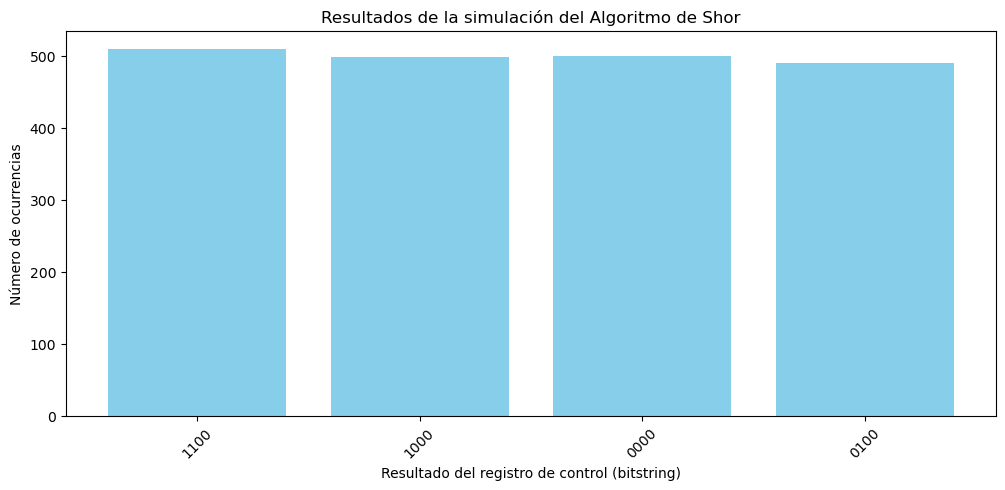

Resultado más frecuente: 1100 -> y=12
Fracción aproximada y/q: 3/4 -> periodo estimado r ≈ 4
Factores estimados de 15: 3, 5


In [267]:

from qiskit import QuantumCircuit, generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit import transpile
import matplotlib.pyplot as plt
import numpy as np
from fractions import Fraction
from math import gcd
from qiskit.visualization import plot_histogram

service = QiskitRuntimeService()
#backend = service.backend("ibm_marrakesh")
backend = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=2, backend=backend)
 
transpiled_circuit = pm.run(circ)
 
job = simulator.run(transpiled_circuit, shots=SHOTS)
result = job.result()

# Obtener los conteos
counts = result.get_counts()
print("Conteo de resultados (registro de control):")
print(counts)

# -------------------------------
# Visualización del histograma
# -------------------------------
# Preparar los datos
bitstrings = list(counts.keys())
frequencies = list(counts.values())

# Crear el histograma
plt.figure(figsize=(12,5))
plt.bar(bitstrings, frequencies, color='skyblue')
plt.xlabel('Resultado del registro de control (bitstring)')
plt.ylabel('Número de ocurrencias')
plt.title('Resultados de la simulación del Algoritmo de Shor')
plt.xticks(rotation=45)
plt.show()

# -------------------------------
# Post-procesamiento clásico: estimar el período r
# -------------------------------
# Tomamos el resultado más frecuente (puede ser más de uno)
most_common = max(counts, key=counts.get)
# Convertimos el bitstring medido a número entero
y = int(most_common, 2)
q = 2**len(circ.qregs[0])  # tamaño del registro de control
fraction = Fraction(y, q).limit_denominator(N)  # aproximación fraccionaria
r_estimated = fraction.denominator

print(f"Resultado más frecuente: {most_common} -> y={y}")
print(f"Fracción aproximada y/q: {fraction} -> periodo estimado r ≈ {r_estimated}")

# -------------------------------
# Post-procesamiento para factores de N
# -------------------------------
a = 2  # base utilizada
if r_estimated % 2 != 0 or a**(r_estimated//2) % N == N-1:
    print("Período impar o caso especial, no se puede factorizar con este resultado")
else:
    factor1 = gcd(a**(r_estimated//2) - 1, N)
    factor2 = gcd(a**(r_estimated//2) + 1, N)
    print(f"Factores estimados de {N}: {factor1}, {factor2}")


# Dinámica de un Spin-½ bajo Hamiltoniano con Ruido

En este ejemplo estudiamos la evolución de un **spin-½** sometido a un **campo magnético tridimensional**:

$$
\hat{H} = -\frac{\gamma}{2} (B_x \sigma_x + B_y \sigma_y + B_z \sigma_z)
$$

donde:
- $\gamma$ es la razón giromagnética,
- $B_x, B_y, B_z$ son las componentes del campo magnético,
- $\sigma_x, \sigma_y, \sigma_z$ son los operadores de Pauli.

---

## 1. Estado Inicial

El spin se inicializa en la **superposición equitativa**:

$$
|\psi_0\rangle = |+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}
$$

que corresponde a un vector en el **eje X de la esfera de Bloch**.

---

## 2. Evolución Ideal

La evolución bajo el Hamiltoniano se realiza mediante la **ecuación de Schrödinger**:

$$
|\psi(t)\rangle = e^{-i \hat{H} t / \hbar} |\psi_0\rangle
$$

En nuestro código, esta evolución se implementa usando **rotaciones cuánticas** en Qiskit:

- $\text{Rx}(-\gamma B_x t)$ → rotación alrededor de X
- $\text{Ry}(-\gamma B_y t)$ → rotación alrededor de Y
- $\text{Rz}(-\gamma B_z t)$ → rotación alrededor de Z

Esto permite calcular las **expectaciones** de los operadores de Pauli:

$$
\langle \sigma_x \rangle, \quad \langle \sigma_y \rangle, \quad \langle \sigma_z \rangle
$$

que se usan para graficar la trayectoria en la **esfera de Bloch**.

---

## 3. Evolución con Ruido

Para simular **ruidos parásitos** o **diafonía**, se agregan perturbaciones aleatorias a cada componente del campo:

$$
B_x \to B_x + \delta B_x, \quad
B_y \to B_y + \delta B_y, \quad
B_z \to B_z + \delta B_z
$$

donde $\delta B_i$ son valores aleatorios pequeños. Esto permite observar cómo la coherencia del spin se degrada respecto a la evolución ideal.

---

## 4. Visualización

Se grafica la trayectoria como un **scatter 3D** sobre la esfera de Bloch:

- Azul → evolución ideal
- Rojo → evolución con ruido
- Esfera translúcida de referencia para la orientación del spin



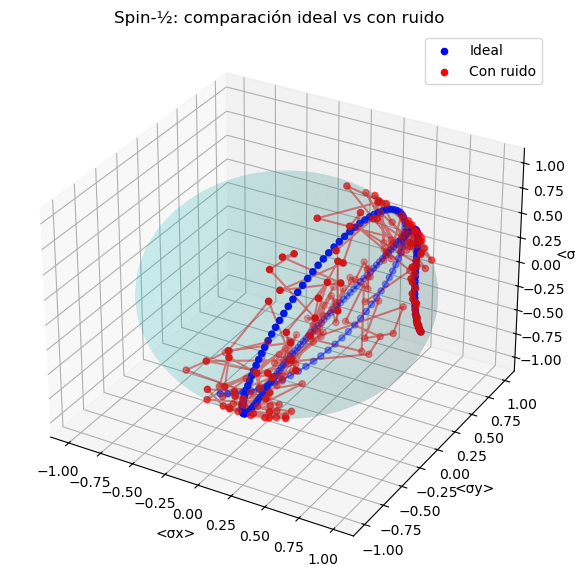

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator

# Parámetros
gamma = 1.0
B = np.array([1.0, 0.5, 0.3])  # Campo magnético en x, y, z
noise_strength = 0.05
t_max = 10.0
n_steps = 200
times = np.linspace(0, t_max, n_steps)

# Estado inicial |+> = (|0> + |1>)/√2
psi0 = Statevector.from_label('0')
qc_init = QuantumCircuit(1)
qc_init.h(0)
psi0 = psi0.evolve(Operator(qc_init))

# Arrays para almacenar expectativas
expect_x_ideal, expect_y_ideal, expect_z_ideal = [], [], []
expect_x_noise, expect_y_noise, expect_z_noise = [], [], []

for t in times:
    # --- Evolución ideal ---
    qc_ideal = QuantumCircuit(1)
    qc_ideal.rz(-gamma*B[2]*t, 0)
    qc_ideal.ry(-gamma*B[1]*t, 0)
    qc_ideal.rx(-gamma*B[0]*t, 0)
    psi_ideal = psi0.evolve(Operator(qc_ideal))
    
    expect_x_ideal.append(psi_ideal.expectation_value(Operator.from_label('X')).real)
    expect_y_ideal.append(psi_ideal.expectation_value(Operator.from_label('Y')).real)
    expect_z_ideal.append(psi_ideal.expectation_value(Operator.from_label('Z')).real)
    
    # --- Evolución con ruido ---
    qc_noise = QuantumCircuit(1)
    noise = noise_strength * (2*np.random.rand(3) - 1)
    qc_noise.rz(-gamma*(B[2]+noise[2])*t, 0)
    qc_noise.ry(-gamma*(B[1]+noise[1])*t, 0)
    qc_noise.rx(-gamma*(B[0]+noise[0])*t, 0)
    psi_noise = psi0.evolve(Operator(qc_noise))
    
    expect_x_noise.append(psi_noise.expectation_value(Operator.from_label('X')).real)
    expect_y_noise.append(psi_noise.expectation_value(Operator.from_label('Y')).real)
    expect_z_noise.append(psi_noise.expectation_value(Operator.from_label('Z')).real)

# Scatter 3D
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

# Trayectoria ideal
ax.scatter(expect_x_ideal, expect_y_ideal, expect_z_ideal, c='blue', label='Ideal', s=20)
ax.plot(expect_x_ideal, expect_y_ideal, expect_z_ideal, color='blue', alpha=0.5)

# Trayectoria con ruido
ax.scatter(expect_x_noise, expect_y_noise, expect_z_noise, c='red', label='Con ruido', s=20)
ax.plot(expect_x_noise, expect_y_noise, expect_z_noise, color='red', alpha=0.5)

# Esfera de Bloch de referencia
u = np.linspace(0, 2*np.pi, 50)
v = np.linspace(0, np.pi, 50)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x_sphere, y_sphere, z_sphere, color='c', alpha=0.1)

ax.set_xlabel('<σx>')
ax.set_ylabel('<σy>')
ax.set_zlabel('<σz>')
ax.set_title('Spin-½: comparación ideal vs con ruido')
ax.legend()
plt.show()



# VQE: Espín ½ en un campo magnético

## 1. Sistema físico
Consideramos un **spin-½** en un campo magnético estático en la dirección Z.  
El **Hamiltoniano** del sistema es:  

$$
H = \frac{1}{2} \sigma_z
$$

donde $\sigma_z$ es la matriz de Pauli Z:

$$
\sigma_z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

El valor esperado de la energía para un estado $|\psi\rangle$ es:

$$
E(\psi) = \langle \psi | H | \psi \rangle
$$

El **valor mínimo exacto** de $H$ es $-0.5$, correspondiente al estado $|1\rangle$.

---

## 2. Ansatz variacional
En VQE usamos un **circuito parametrizado** (ansatz) para aproximar el estado fundamental:

$$
|\psi(\theta)\rangle = R_y(\theta)|0\rangle = \cos(\theta/2)|0\rangle + \sin(\theta/2)|1\rangle
$$

- $R_y(\theta)$ rota el qubit alrededor del eje Y por un ángulo $\theta$.  
- El parámetro $\theta$ será optimizado para minimizar la energía esperada.

---

## 3. Expectación de energía
Medimos el qubit en la base computacional y calculamos:

$$
\langle \sigma_z \rangle = P_0 - P_1
$$

donde $P_0$ y $P_1$ son las probabilidades de medir $|0\rangle$ y $|1\rangle$.  
Entonces, la energía esperada es:

$$
E(\theta) = \frac{1}{2} \langle \sigma_z \rangle
$$

---

## 4. Optimización clásica
- La función objetivo de VQE es $E(\theta)$, que depende del parámetro $\theta$.  
- Se usa un optimizador clásico (COBYLA) para encontrar $\theta_\text{opt}$ que **minimiza $E(\theta)$**.  
- El resultado aproximará el estado fundamental del Hamiltoniano.

---

## 5. Convergencia
- La **convergencia de la energía** a lo largo de las iteraciones muestra cómo el algoritmo ajusta $\theta$ para aproximarse al valor mínimo exacto.  
- La energía exacta se puede superponer para comparar:

$$
E_\text{exact} = -0.5
$$


======= RESULTADO VQE =======
Theta óptimo: 3.1842 rad
Energía mínima: -0.4998
Valor exacto esperado: -0.5


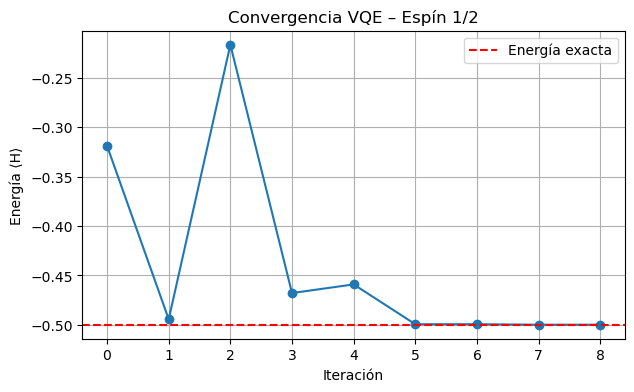

In [8]:
# ============================================
# VQE mínimo – Espín 1/2 en campo magnético
# Hamiltoniano H = (1/2) Z
# Qiskit 2.x
# ============================================

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# --------------------------------------------
# Parámetros globales
# --------------------------------------------
SHOTS = 4000
energy_history = []

backend = AerSimulator()
sampler = Sampler(mode=backend)

# --------------------------------------------
# Ansatz variacional
# --------------------------------------------
def ansatz(theta):
    qc = QuantumCircuit(1, 1)
    qc.ry(theta, 0)
    qc.measure(0, 0)
    return qc

# --------------------------------------------
# Función objetivo del VQE
# --------------------------------------------
theta_history=[]   # lista de thetas evaluados

def objective(theta):
    qc = ansatz(theta[0])

    pm = generate_preset_pass_manager(
        backend=backend,
        optimization_level=1
    )
    qc_isa = pm.run(qc)

    result = sampler.run([qc_isa], shots=SHOTS).result()[0]

    # FIX CORRECTO PARA QISKIT 2.x
    counts = result.data.c.get_counts()


    # Expectation value <Z>
    p0 = counts.get('0', 0) / SHOTS
    p1 = counts.get('1', 0) / SHOTS
    exp_z = p0 - p1

    energy = 0.5 * exp_z
    energy_history.append(energy)
    theta_history.append(energy)
    return energy

# --------------------------------------------
# Optimización clásica
# --------------------------------------------
theta_init = np.random.uniform(0, 2*np.pi)

res = minimize(
    fun=objective,
    x0=[theta_init],
    method="COBYLA",
    options={"maxiter": 100}
)

# --------------------------------------------
# Resultados
# --------------------------------------------
theta_opt = res.x[0]
energy_min = res.fun

print("======= RESULTADO VQE =======")
print(f"Theta óptimo: {theta_opt:.4f} rad")
print(f"Energía mínima: {energy_min:.4f}")
print("Valor exacto esperado: -0.5")
print("=============================")

# --------------------------------------------
# Gráfica de convergencia
# --------------------------------------------
plt.figure(figsize=(7,4))
plt.plot(energy_history, marker='o')
plt.axhline(-0.5, color='r', linestyle='--', label='Energía exacta')
plt.xlabel("Iteración")
plt.ylabel("Energía ⟨H⟩")
plt.title("Convergencia VQE – Espín 1/2")
plt.legend()
plt.grid(True)
plt.show()


# **QAOA para un problema de mochila mínima (3 productos, 10 kg)**

## 1 Formulación del problema

Supongamos que tenemos 3 productos con pesos y valores:

| Producto | Peso (kg) | Valor |
|----------|-----------|-------|
| A        | 4         | 10    |
| B        | 3         | 5     |
| C        | 5         | 8     |

La mochila tiene una **capacidad máxima** de 10 kg.

Definimos **variables binarias** \(x_i\):

$$
x_i =
\begin{cases}
1 & \text{si el producto $i$ se incluye en la mochila} \\
0 & \text{si no se incluye}
\end{cases}
$$

### Objetivo: maximizar el valor total

$$
V(x_1, x_2, x_3) = 10 x_1 + 5 x_2 + 8 x_3
$$

### Restricción de peso

$$
W(x_1, x_2, x_3) = 4 x_1 + 3 x_2 + 5 x_3 \le 10
$$

---

## 2 Hamiltoniano de costo para QAOA

QAOA busca **minimizar energía**, así que definimos un Hamiltoniano de costo \(H_C\) que combine:

1. Maximización del valor (negativo, para minimizar)
2. Penalización si se supera la capacidad

$$
H_C = - (10 x_1 + 5 x_2 + 8 x_3) + P \cdot \max(0, 4 x_1 + 3 x_2 + 5 x_3 - 10)^2
$$

- \(P\) es un **factor de penalización** grande (e.g., 20)  
- El término cuadrático penaliza soluciones que exceden la capacidad

**Interpretación**:  
- Si la solución respeta la restricción, el segundo término es 0  
- Si excede 10 kg, la energía aumenta y QAOA lo evita

---

## 3 Hamiltoniano mezclador

Para explorar el espacio de soluciones, usamos un mezclador:

$$
H_M = X_1 + X_2 + X_3
$$

- \(X_i\) son las matrices de **Pauli-X**  
- Aplicar \(e^{-i \beta H_M}\) rota cada qubit y permite que el algoritmo explore combinaciones

---

## 4 Circuito QAOA (profundidad p)

1. Inicialización: todos los qubits en superposición \(|+\rangle\)
   $$
   |+\rangle^{\otimes 3} = \frac{1}{\sqrt{8}} \sum_{x \in \{0,1\}^3} |x\rangle
   $$
2. Aplicar \(U_C(\gamma) = e^{-i \gamma H_C}\) para penalizar las soluciones no óptimas
3. Aplicar \(U_M(\beta) = e^{-i \beta H_M}\) para mezclar
4. Repetir los pasos 2 y 3 **p veces** (profundidad QAOA)
5. Medir todos los qubits
6. Interpretar los resultados como **combinación de productos óptima**

---

## 5 Interpretación matemática

- Cada qubit \(i\) representa un producto  
- Cada bitstring medido corresponde a una **solución candidata**  
- La probabilidad más alta indica la **mejor combinación de productos** según QAOA


management.get:WARNING:2025-12-19 23:36:56,734: Loading default saved account


Usando el backend aer_simulator
γ=0.500, β=0.500 → energía=878.7990
γ=1.500, β=0.500 → energía=1054.0397
γ=0.500, β=1.500 → energía=1042.0552
γ=-0.232, β=-0.182 → energía=997.8724
γ=0.944, β=0.270 → energía=967.2055
γ=0.433, β=0.741 → energía=926.7220
γ=0.452, β=0.487 → energía=1112.6411
γ=0.597, β=0.523 → energía=840.3759
γ=0.695, β=0.503 → energía=991.5667
γ=0.583, β=0.622 → energía=829.6236
γ=0.674, β=0.663 → energía=1190.4233
γ=0.533, β=0.616 → energía=961.0297
γ=0.581, β=0.634 → energía=850.4568
γ=0.605, β=0.611 → energía=803.8939
γ=0.611, β=0.587 → energía=785.0277
γ=0.631, β=0.573 → energía=782.7130
γ=0.626, β=0.564 → energía=775.1756
γ=0.617, β=0.546 → energía=749.3649
γ=0.592, β=0.515 → energía=856.0797
γ=0.637, β=0.545 → energía=854.5277
γ=0.617, β=0.541 → energía=751.1726
γ=0.607, β=0.547 → energía=817.0047
γ=0.627, β=0.546 → energía=775.0857
γ=0.612, β=0.547 → energía=767.7570
γ=0.620, β=0.546 → energía=744.4528
γ=0.622, β=0.547 → energía=746.0182
γ=0.620, β=0.547 → energía

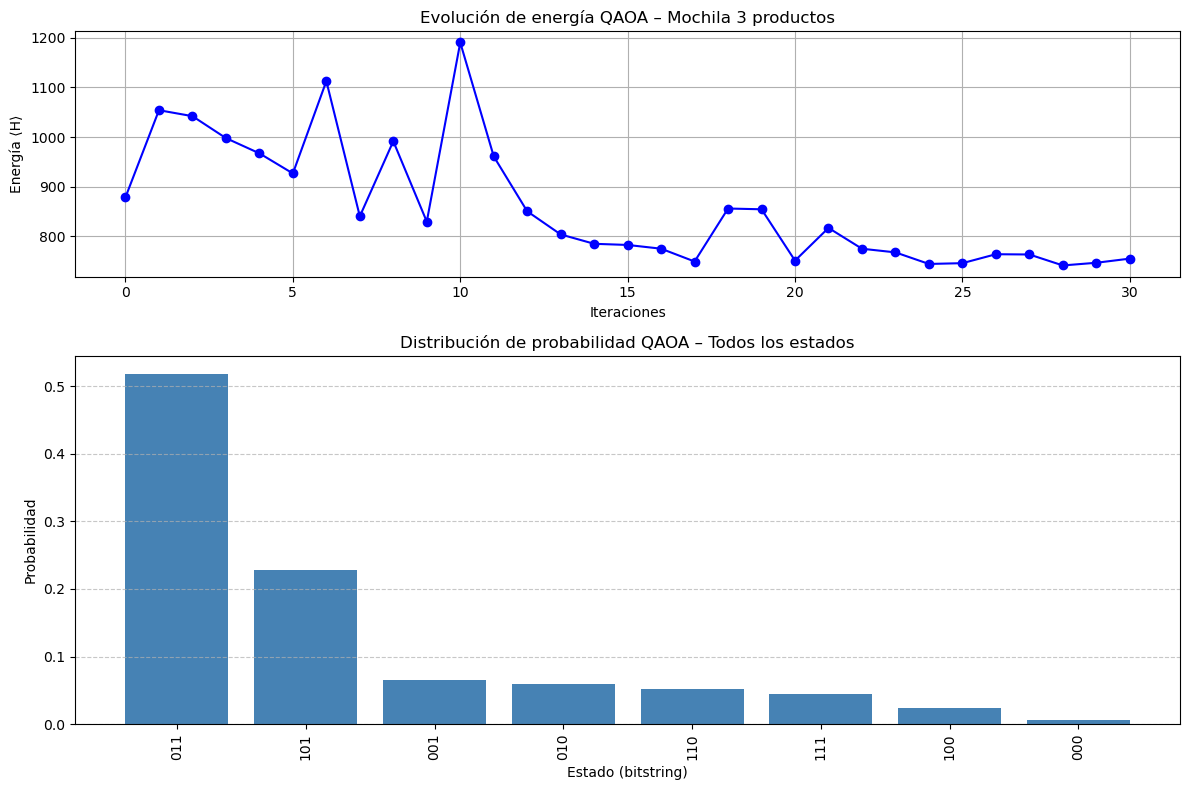

In [221]:
# ============================================
# QAOA – Mochila 5 productos / 10 kg
# Backend real IBM
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
from qiskit.transpiler import generate_preset_pass_manager
from scipy.optimize import minimize

# ============================================
# 1 Datos de la mochila
# ============================================
weights = np.array([4, 3, 5])        # peso de cada producto
values = np.array([10, 5, 8])         # valor de cada producto
max_weight = 10                             # capacidad máxima

n_qubits = len(weights)

# ============================================
# 2 Construcción del Hamiltoniano (penalización por exceso)
# H = -Σ v_i Z_i + A*(Σ w_i Z_i - W_max)^2
# ============================================
A = 2.0  # penalización
pauli_list = []

# Términos lineales de valor
for i, v in enumerate(values):
    pauli = ["I"]*n_qubits
    pauli[i] = "Z"
    pauli_list.append(("".join(pauli), -v/2))  # dividido por 2 para correspondencia con Z=±1

# Términos de penalización (Σ w_i Z_i - W_max)^2
# Expandimos el cuadrado y agregamos coeficientes
for i in range(n_qubits):
    pauli = ["I"]*n_qubits
    pauli[i] = "Z"
    pauli_list.append(("".join(pauli), A * (weights[i]**2)/4))
    
    for j in range(i+1, n_qubits):
        pauli = ["I"]*n_qubits
        pauli[i] = "Z"
        pauli[j] = "Z"
        pauli_list.append(("".join(pauli), A * weights[i]*weights[j]/2))

# Constante del término cuadrático y lineal de W_max
const = A * (sum(weights)/2 - max_weight)**2
pauli_list.append(("I"*n_qubits, const))

# Crear SparsePauliOp
hamiltonian_op = SparsePauliOp.from_list(pauli_list)

# ============================================
# 3 Operador de coste U_C(γ)
# ============================================
def apply_cost_unitary(qc, gamma):
    """Aplica U_C(γ) según Hamiltoniano"""
    for pauli, coeff in pauli_list:
        indices = [i for i, p in enumerate(pauli) if p=="Z"]
        if len(indices) == 1:
            qc.rz(2*gamma*coeff, indices[0])
        elif len(indices) == 2:
            qc.cx(indices[0], indices[1])
            qc.rz(2*gamma*coeff, indices[1])
            qc.cx(indices[0], indices[1])
        else:
            # constante o término global
            qc.global_phase += 2*gamma*coeff

# ============================================
# 4 Mezclador estándar U_M(β)
# ============================================
def apply_mixer_unitary(qc, beta):
    for q in range(n_qubits):
        qc.rx(2*beta, q)

# ============================================
# 5 Circuito QAOA p=1
# ============================================
def build_qaoa_circuit(gamma, beta):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # estado inicial uniforme
    apply_cost_unitary(qc, gamma)
    apply_mixer_unitary(qc, beta)
    return qc

# ============================================
# 6 Selección de backend
# ============================================
service = QiskitRuntimeService()
backend=AerSimulator()
#backend = service.backend("ibm_torino")
print(f"Usando el backend {backend.name}")

objective_vals = []
beta_par = []
gamma_par=[]
# ============================================
# 7 Función de energía
# ============================================
def energy(params):
    gamma, beta = params
    qc = build_qaoa_circuit(gamma, beta)

    pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
    isa_circuit = pm.run(qc)

    estimator = Estimator(mode=backend)
    estimator.options.resilience_level = 1
    estimator.options.default_shots = 1000

    mapped_observables = [observable.apply_layout(isa_circuit.layout) for observable in hamiltonian_op]

    job = estimator.run([(isa_circuit, mapped_observables)])
    result = job.result()
    cost = result[0].data.evs
    fval = (np.real(hamiltonian_op.coeffs).dot(cost))
    objective_vals.append(fval)
    beta_par.append(beta)
    gamma_par.append(gamma)
    print(f"γ={gamma:.3f}, β={beta:.3f} → energía={fval:.4f}")
    return fval

# ============================================
# 8 Optimización clásica (COBYLA)
# ============================================
maxiter=30
params0 = [0.5, 0.5]  # valores iniciales
res = minimize(energy, params0, method="COBYLA", tol=1e-4, options={"maxiter": maxiter})

gamma_opt, beta_opt = res.x
print("\n========= RESULTADO OPTIMIZACIÓN =========")
print(f"Gamma* = {gamma_opt:.4f}")
print(f"Beta*  = {beta_opt:.4f}")
print(f"Energía mínima ≈ {energy(res.x):.4f}")
print("==========================================")

# ============================================
# 9 Estado final y probabilidades
# ============================================
qc_opt = build_qaoa_circuit(gamma_opt, beta_opt)
state = Statevector.from_instruction(qc_opt)
probs = state.probabilities_dict()

print("\n========= PROBABILIDADES =========")
for bitstring, p in probs.items():
    print(f"{bitstring}: {p:.6f}")

best_state = max(probs, key=probs.get)
print("\n========= SOLUCIÓN (ESTADO MÁS PROBABLE) =========")
print(f"Estado óptimo = {best_state}")
print(f"Probabilidad = {probs[best_state]:.6f}")
print("===============================================")

# ============================================
# 10 Graficar evolución de energía
# ============================================
# Crear figura con 2 subplots verticales
fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 1.5]})

# ---------------------------
# Evolución de energía
# ---------------------------
axes[0].plot(objective_vals, marker='o', linestyle='-', color='b')
axes[0].set_title('Evolución de energía QAOA – Mochila 3 productos')
axes[0].set_xlabel('Iteraciones')
axes[0].set_ylabel('Energía ⟨H⟩')
axes[0].grid(True)

# ---------------------------
# 2 Distribución de probabilidades
# ---------------------------
# Ordenar de mayor a menor
sorted_items = sorted(probs.items(), key=lambda x: x[1], reverse=True)
states = [s[::-1] for s, _ in sorted_items]  # invertir bits para interpretación física
values = [p for _, p in sorted_items]

axes[1].bar(states, values, color='steelblue')
axes[1].set_xlabel("Estado (bitstring)")
axes[1].set_ylabel("Probabilidad")
axes[1].set_title("Distribución de probabilidad QAOA – Todos los estados")
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


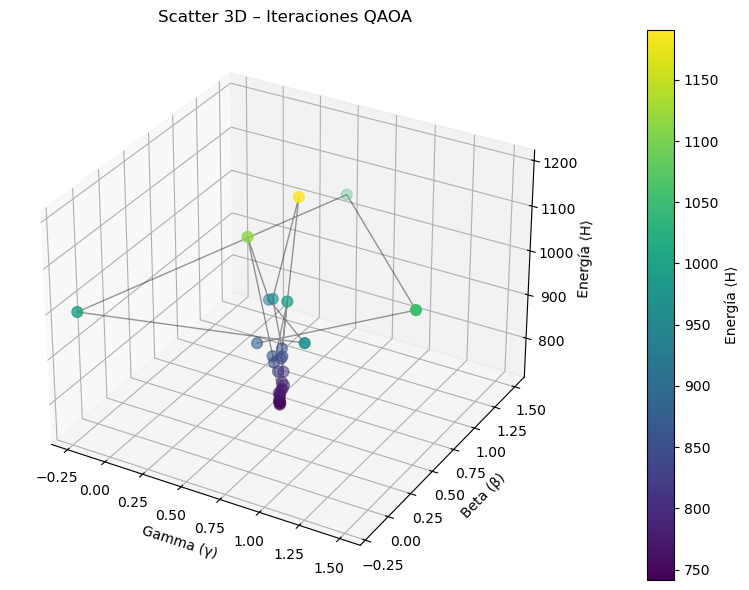

In [222]:
# ============================================
# Scatter 3D simple: iteraciones QAOA
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

gamma_scatter  = np.array(gamma_par)
beta_scatter   = np.array(beta_par)
energy_scatter = np.array(objective_vals)

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    gamma_scatter,
    beta_scatter,
    energy_scatter,
    c=energy_scatter,
    cmap='viridis',
    s=60
)

ax.set_xlabel('Gamma (γ)')
ax.set_ylabel('Beta (β)')
ax.set_zlabel('Energía ⟨H⟩')
ax.set_title('Scatter 3D – Iteraciones QAOA')

cbar = plt.colorbar(sc, pad=0.1)
cbar.set_label('Energía ⟨H⟩')

plt.tight_layout()

ax.plot(
    gamma_scatter,
    beta_scatter,
    energy_scatter,
    color='black',
    alpha=0.4,
    linewidth=1
)
plt.show()


In [223]:
# ============================================
# Superficie 3D interactiva de energía QAOA con Plotly
# ============================================

import numpy as np
import plotly.graph_objects as go
from scipy.interpolate import griddata

# Crear malla fina
gamma_fine = np.linspace(0, np.pi, 50)
beta_fine  = np.linspace(0, np.pi, 50)
G, B = np.meshgrid(gamma_fine, beta_fine)

# Interpolación cúbica de los datos
points = np.column_stack((gamma_par, beta_par))  # puntos originales
E_grid = griddata(points, objective_vals, (G, B), method='cubic')

# Crear figura de Plotly
fig = go.Figure()

# Añadir superficie interpolada
fig.add_trace(go.Surface(
    x=G,
    y=B,
    z=E_grid,
    colorscale='Viridis',
    colorbar=dict(title='Energía ⟨H⟩'),
    showscale=True,
    opacity=0.9
))

# Opcional: añadir scatter de los puntos originales
fig.add_trace(go.Scatter3d(
    x=gamma_par,
    y=beta_par,
    z=objective_vals,
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Iteraciones originales'
))

# Configuración de layout
fig.update_layout(
    title='Superficie de energía QAOA – Mochila 3 productos (interactiva)',
    scene=dict(
        xaxis_title='Gamma (γ)',
        yaxis_title='Beta (β)',
        zaxis_title='Energía ⟨H⟩',
    ),
    width=900,
    height=700
)

fig.show()


In [184]:
def run_qaoa_knapsack(
    weights,
    values,
    max_weight,
    p=1,
    A= 2 * np.sum(values),
    backend=None,
    maxiter=30
):
    import numpy as np
    from qiskit import QuantumCircuit
    from qiskit.quantum_info import Statevector, SparsePauliOp
    from qiskit_aer import AerSimulator
    from qiskit_ibm_runtime import Estimator
    from qiskit.transpiler import generate_preset_pass_manager
    from scipy.optimize import minimize
    from scipy.interpolate import griddata
    import plotly.graph_objects as go

    if backend is None:
        backend = AerSimulator()

    n_qubits = len(weights)

    # ================================
    # 1. Construcción Hamiltoniano
    # ================================
    pauli_list = []

    # Términos de valor
    for i, v in enumerate(values):
        pauli = ["I"] * n_qubits
        pauli[i] = "Z"
        pauli_list.append(("".join(pauli), -v / 2))

    # Penalización cuadrática
    for i in range(n_qubits):
        pauli = ["I"] * n_qubits
        pauli[i] = "Z"
        pauli_list.append(("".join(pauli), A * weights[i] ** 2 / 4))

        for j in range(i + 1, n_qubits):
            pauli = ["I"] * n_qubits
            pauli[i] = "Z"
            pauli[j] = "Z"
            pauli_list.append(
                ("".join(pauli), A * weights[i] * weights[j] / 2)
            )

    const = A * (sum(weights) / 2 - max_weight) ** 2
    pauli_list.append(("I" * n_qubits, const))

    H = SparsePauliOp.from_list(pauli_list)

    # ================================
    # 2. Operadores QAOA
    # ================================
    def apply_cost(qc, gamma):
        for pauli, coeff in pauli_list:
            idx = [i for i, p in enumerate(pauli) if p == "Z"]
            if len(idx) == 1:
                qc.rz(2 * gamma * coeff, idx[0])
            elif len(idx) == 2:
                qc.cx(idx[0], idx[1])
                qc.rz(2 * gamma * coeff, idx[1])
                qc.cx(idx[0], idx[1])
            else:
                qc.global_phase += 2 * gamma * coeff

    def apply_mixer(qc, beta):
        for q in range(n_qubits):
            qc.rx(2 * beta, q)

    def build_circuit(gamma, beta):
        qc = QuantumCircuit(n_qubits)
        qc.h(range(n_qubits))
        apply_cost(qc, gamma)
        apply_mixer(qc, beta)
        return qc

    # ================================
    # 3. Función objetivo
    # ================================
    energy_hist = []
    gamma_hist = []
    beta_hist = []

    def energy(params):
        gamma, beta = params
        qc = build_circuit(gamma, beta)

        pm = generate_preset_pass_manager(
            backend=backend, optimization_level=2
        )
        qc_isa = pm.run(qc)

        estimator = Estimator(mode=backend)
        estimator.options.default_shots = 10000

        mapped_obs = [op.apply_layout(qc_isa.layout) for op in H]

        job = estimator.run([(qc_isa, mapped_obs)])
        evs = job.result()[0].data.evs

        E = np.real(H.coeffs).dot(evs)

        gamma_hist.append(gamma)
        beta_hist.append(beta)
        energy_hist.append(E)

        #print(f"γ={gamma:.3f}, β={beta:.3f} → E={E:.4f}")
        return E

    # ================================
    # 4. Optimización
    # ================================
    res = minimize(
        energy,
        x0=[0.5, 0.5],
        method='COBYLA', 
        tol=0.001, 
        options={'maxiter': maxiter},

    )


    gamma_opt, beta_opt = res.x

    # ================================
    # 5. Estado final
    # ================================
    qc_opt = build_circuit(gamma_opt, beta_opt)
    state = Statevector.from_instruction(qc_opt)
    probs = state.probabilities_dict()

    best_state = max(probs, key=probs.get)
    top5_states = sorted(probs, key=probs.get, reverse=True)[:5]
    
    # ================================
    # 6. Superficie 3D Plotly
    # ================================
    gamma_f = np.linspace(0, np.pi, 100)
    beta_f  = np.linspace(0, np.pi, 100)
    G, B = np.meshgrid(gamma_f, beta_f)

    points = np.column_stack((gamma_hist, beta_hist))
    E_grid = griddata(points, energy_hist, (G, B), method="cubic")

    fig = go.Figure(
        data=[go.Surface(x=G, y=B, z=E_grid, colorscale="Viridis")]
    )

    fig.update_layout(
        title="Superficie de energía QAOA – Mochila",
        scene=dict(
            xaxis_title="Gamma (γ)",
            yaxis_title="Beta (β)",
            zaxis_title="⟨H⟩"
        ),
        width=800,
        height=700
    )
    
    # Ordenar de mayor a menor probabilidad

    sorted_items = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]

    # Estados y probabilidades (orden físico)
    statesb = [s[::-1] for s, _ in sorted_items]
    valuesb = [p for _, p in sorted_items]

    fig2 = go.Figure()

    fig2.add_trace(
        go.Bar(
            x=statesb,
            y=valuesb,
            marker=dict(color=values, colorscale="Viridis"),
        )
    )

    fig2.update_layout(
        title="Estados QAOA – Mochila" or f"Top {5} estados más probables",
        xaxis_title="Estado (bitstring)",
        yaxis_title="Probabilidad",
        xaxis_tickangle=-45,
        template="plotly_white",
        height=400,
        width=800
    )


    return {
        "gamma_opt": gamma_opt,
        "beta_opt": beta_opt,
        "energy_min": res.fun,
        "best_state": best_state,
        "top_5_states":top5_states,
        "probability": probs[best_state],
        "probs": probs,
        "energy_history": energy_hist,
        "figure_3d": fig,
        "figure_bar": fig2,
        "full_statevector":state
    }




In [187]:
result = run_qaoa_knapsack(
    weights=[200,100,500,700,100],
    values=[60,40,20,10,50],
    max_weight=1000,
    maxiter=30
)

print(result["best_state"])
print(result["probability"])
result["figure_3d"].show()
result["figure_bar"].show()

10100
0.11679056560793472
